# Introduction to Quantum Computing Project - Binary Classification on the Parity problem


This notebook demonstrates a quantum machine learning approach to binary classification
using the parity problem as an example. It's challenging for classical neural networks but can be handled efficiently with quantum methods using PennyLane.

In [ ]:
# Install required libraries if not already installed.
# PennyLane for quantum computing, Pandas for data handling, Matplotlib for visualization.

In [ ]:
%pip install pennylane
%pip install pandas
%pip install matplotlib

In [ ]:
# Import necessary modules:
# - pandas for data manipulation
# - pennylane (qml) for quantum circuit construction and simulation
# - pennylane.numpy (np) for compatible numpy operations (autograd support)
# - matplotlib.pyplot for 2D plotting
# - Axes3D from mpl_toolkits.mplot3d for 3D visualization
# - google.colab.drive for mounting Google Drive to access data files

In [ ]:
import pandas as pd
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# Mount Google Drive to access dataset files stored there.
# This allows persistent storage and access in Colab environment.

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data
Data is generated using the parity function. The parity function is a function that returns 1 if the number of 1s in the input is odd, and 0 otherwise. The input is a binary string of length n. The parity function is a well-known example of a function that is not efficiently learnable by a classical neural network. However, it can be learned efficiently by a quantum neural network.

## Read
Define the base path for data files stored in Google Drive.
Load training and testing data for two classes (A and B) from .dat files using np.loadtxt.

In [ ]:

base_path = "/content/drive/MyDrive/Colab Notebooks/data"

train_classA = np.loadtxt(f"{base_path}/classA_train.dat")
train_classB = np.loadtxt(f"{base_path}/classB_train.dat")
test_classA = np.loadtxt(f"{base_path}/classA_test.dat")
test_classB = np.loadtxt(f"{base_path}/classB_test.dat")
train_data = np.vstack((train_classA, train_classB))
train_labels = np.hstack((np.zeros(len(train_classA)), np.ones(len(train_classB))))

## Preprocess
Subtract 0.5 from all data points in both classes for training and testing.
This centers the data around zero, which can help with quantum encoding or normalization.

In [ ]:
train_classA -= 0.5
train_classB -= 0.5
test_classA -= 0.5
test_classB -= 0.5

#Creating train and test datasets.

Combine class A and B data vertically for full train/test datasets.

Create labels: 0 for class A, 1 for class B, using horizontal stacking.

In [ ]:
train_data = np.vstack((train_classA, train_classB))
train_labels = np.hstack((np.zeros(len(train_classA)), np.ones(len(train_classB))))

test_data = np.vstack((test_classA, test_classB))
test_labels = np.hstack((np.zeros(len(test_classA)), np.ones(len(test_classB))))

#Preview
Display the training data tensor for inspection. This uses PennyLane's numpy, which supports gradients if needed.

In [ ]:
train_data

tensor([[-0.52136932,  0.51634261,  0.57685187],
        [ 0.47967195,  0.47521001, -0.48276349],
        [ 0.45851495,  0.48880249, -0.47751312],
        [ 0.47287287,  0.50130472, -0.48129676],
        [ 0.4490846 ,  0.49955922, -0.53082429],
        [-0.46906929, -0.51708618, -0.51294948],
        [ 0.40494731,  0.57586463, -0.5228194 ],
        [-0.46868174, -0.51639052, -0.50394778],
        [ 0.45230147,  0.53798005, -0.47490086],
        [ 0.44109225, -0.48876122,  0.49780467],
        [ 0.55928369,  0.53811759, -0.49537057],
        [-0.48554956,  0.5311928 ,  0.53043502],
        [-0.49101668, -0.52985789, -0.49328596],
        [ 0.56489058,  0.52622874, -0.47390937],
        [ 0.50082764, -0.5481794 ,  0.49814355],
        [-0.49541045, -0.46895463, -0.44893712],
        [-0.45864197, -0.47720196, -0.53279515],
        [ 0.56208121, -0.49005089,  0.50610096],
        [-0.57611053,  0.46526223,  0.47765986],
        [ 0.4342591 , -0.49482992,  0.52829108],
        [-0.4194763 

In [ ]:
test_data

tensor([[ 0.4879638 ,  0.54024352, -0.46494221],
        [-0.49177858, -0.51371639, -0.47245236],
        [ 0.49295538, -0.4814586 ,  0.48787918],
        [ 0.55597339,  0.5324364 , -0.49658654],
        [-0.52495464, -0.48868671, -0.51545709],
        [-0.45134428, -0.52187662, -0.53744429],
        [-0.51112591,  0.53013485,  0.51654904],
        [ 0.52916993, -0.49962332,  0.51428079],
        [-0.4897708 ,  0.4922424 ,  0.5334223 ],
        [-0.46431262, -0.45484039, -0.50036212],
        [ 0.51488301, -0.53164158, -0.52451988],
        [-0.49771912,  0.52398959, -0.49891081],
        [-0.50994703,  0.45064989, -0.48652751],
        [ 0.41944514, -0.54143044, -0.54457641],
        [ 0.52296955, -0.50002518, -0.52334696],
        [-0.45378063,  0.47989627, -0.47546236],
        [-0.47659954,  0.4897321 , -0.51949139],
        [-0.4566875 ,  0.51162301, -0.47473584],
        [ 0.45832342,  0.51347606,  0.48019078],
        [ 0.46999107, -0.51461362, -0.50094802]], requires_grad=True)

## Visualizing input data

2-dimensional. showing the difficulty of the problem in a 2-dimensional space.

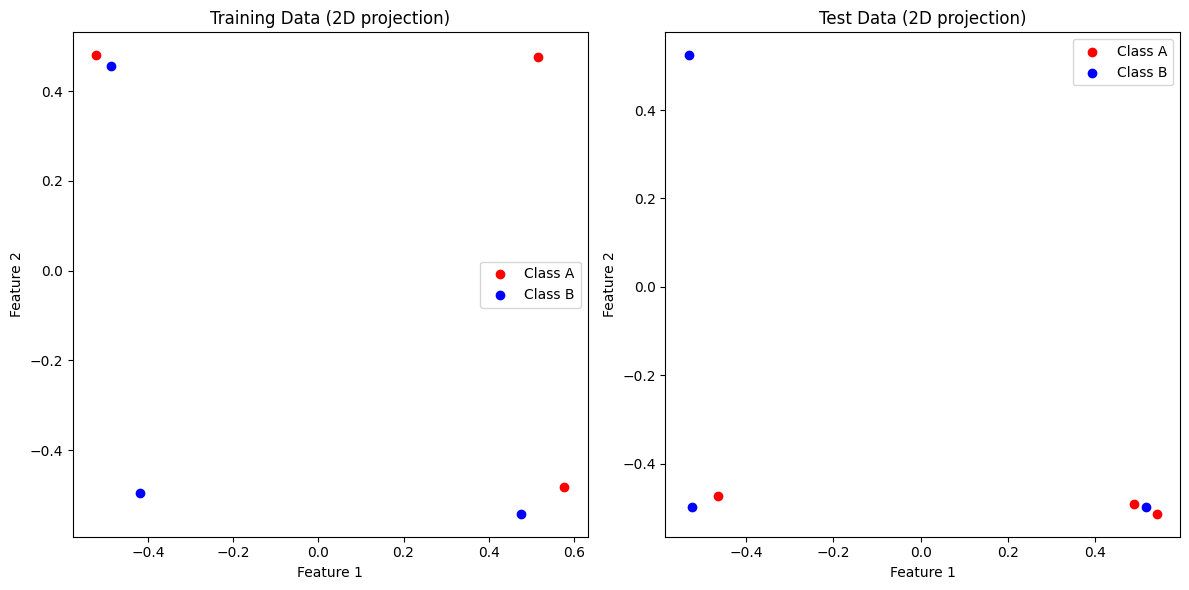

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.scatter(train_classA[0], train_classA[1], color='red', label='Class A')
ax1.scatter(train_classB[0], train_classB[1], color='blue', label='Class B')
ax1.set_title('Training Data (2D projection)')
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')
ax1.legend()

ax2.scatter(test_classA[0], test_classA[1], color='red', label='Class A')
ax2.scatter(test_classB[0], test_classB[1], color='blue', label='Class B')
ax2.set_title('Test Data (2D projection)')
ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Feature 2')
ax2.legend()

plt.tight_layout()
plt.show()

3-dimensional. Cubes are now well separated.

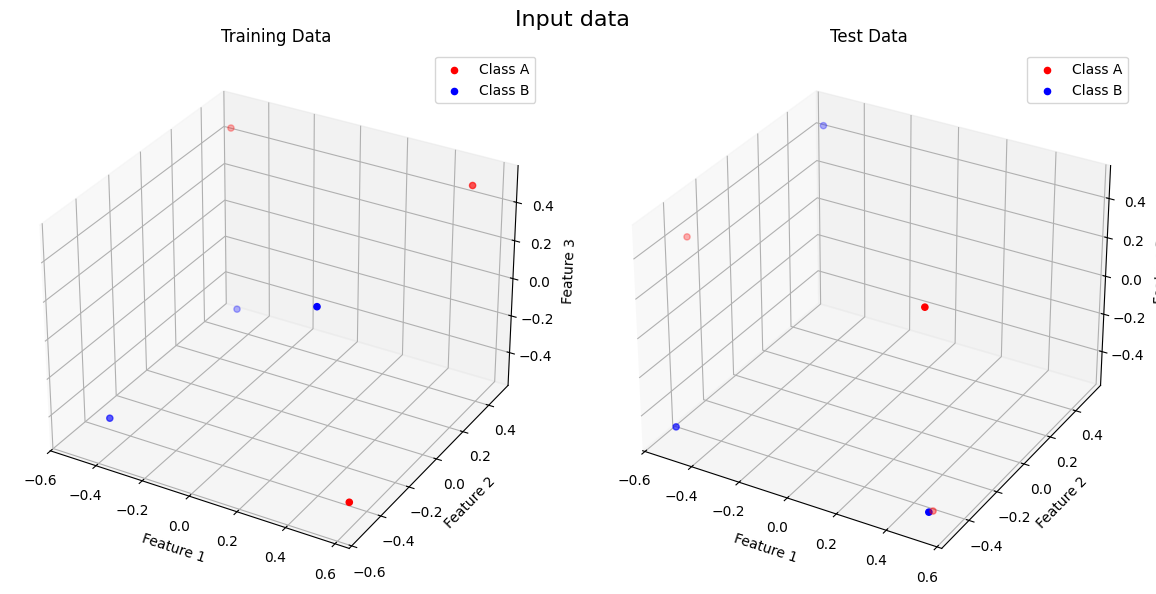

In [ ]:
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(train_classA[0], train_classA[1], train_classA[2], color='red', label='Class A')
ax1.scatter(train_classB[0], train_classB[1], train_classB[2], color='blue', label='Class B')
ax1.set_title('Training Data')
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')
ax1.set_zlabel('Feature 3')
ax1.legend()

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(test_classA[0], test_classA[1], test_classA[2], color='red', label='Class A')
ax2.scatter(test_classB[0], test_classB[1], test_classB[2], color='blue', label='Class B')
ax2.set_title('Test Data')
ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Feature 2')
ax2.set_zlabel('Feature 3')
ax2.legend()

fig.suptitle('Input data', fontsize=16)
plt.tight_layout()
plt.show()

# Quantum Binary Classifier

For building the classifier we have used the pennylane python toolkit.

## Constructing Variational Quantum Circuit (VQC)

Defining the number of qubits and layers.

In [ ]:
num_qubits = 3
dev = qml.device("default.qubit", wires=num_qubits)

In [ ]:
def variational_circuit(weights, x):
    qml.templates.AngleEmbedding(x, wires=range(num_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(num_qubits))

@qml.qnode(dev)
def circuit(weights, x):
    variational_circuit(weights, x)
    return qml.expval(qml.PauliZ(0))

In [ ]:
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

##  Cost function


### Mean Squared Error (MSE) Cost Function

**Definition**:
$$ \text{MSE} = \frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2 $$

where:
- $ N$ is the number of samples.
- $ y_i $ is the true label of the $ i $-th sample.
- $ \hat{y}_i $ is the predicted label of the $ i $-th sample.


In [ ]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2
    loss = loss / len(labels)
    return loss

def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

Initilizing with random parameters following a normal distribution.

In [ ]:
np.random.seed(0)
num_layers = 2
weights_init = 0.01 * np.random.randn(num_layers, num_qubits)
bias_init = np.array(0.0, requires_grad=True)

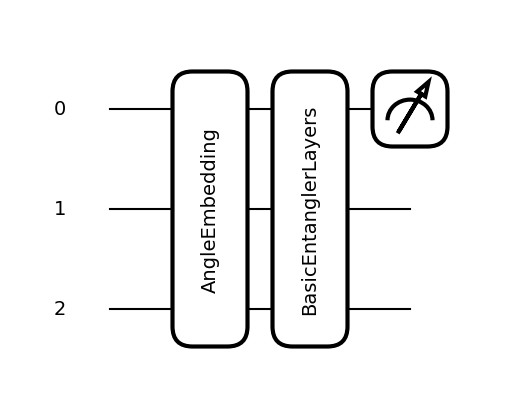

In [ ]:
init_params = weights_init

fig, ax = qml.draw_mpl(circuit)(init_params, np.zeros(num_qubits))
plt.show()

# Training the Quantum Binary Classifier and selecting Optimizer

In [ ]:
from pennylane.optimize import NesterovMomentumOptimizer

opt = NesterovMomentumOptimizer(0.5)
batch_size = 5
weights = weights_init
bias = bias_init

X = train_data
Y = train_labels

for it in range(50):
    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, X_batch, Y_batch)

    predictions = [variational_classifier(weights, bias, x) for x in X]
    acc = np.mean((np.array(predictions) > 0.5) == Y)
    print(f"Iter: {it+1} | Cost: {cost(weights, bias, X, Y):.4f} | Accuracy: {acc:.4f}")
predictions = [variational_classifier(weights, bias, x) for x in test_data]

Iter: 1 | Cost: 0.3305 | Accuracy: 0.5000
Iter: 2 | Cost: 0.2858 | Accuracy: 0.5000
Iter: 3 | Cost: 0.2450 | Accuracy: 0.6000
Iter: 4 | Cost: 0.2471 | Accuracy: 0.6000
Iter: 5 | Cost: 0.2871 | Accuracy: 0.5000
Iter: 6 | Cost: 0.2567 | Accuracy: 0.5000
Iter: 7 | Cost: 0.2777 | Accuracy: 0.5000
Iter: 8 | Cost: 0.3205 | Accuracy: 0.4750
Iter: 9 | Cost: 0.3322 | Accuracy: 0.4000
Iter: 10 | Cost: 0.3344 | Accuracy: 0.4000
Iter: 11 | Cost: 0.2967 | Accuracy: 0.4000
Iter: 12 | Cost: 0.3908 | Accuracy: 0.5000
Iter: 13 | Cost: 0.2631 | Accuracy: 0.4000
Iter: 14 | Cost: 0.3985 | Accuracy: 0.5000
Iter: 15 | Cost: 0.6573 | Accuracy: 0.5000
Iter: 16 | Cost: 0.6386 | Accuracy: 0.5000
Iter: 17 | Cost: 1.8701 | Accuracy: 0.5000
Iter: 18 | Cost: 0.5709 | Accuracy: 0.5250
Iter: 19 | Cost: 0.5692 | Accuracy: 0.5000
Iter: 20 | Cost: 0.3498 | Accuracy: 0.5000
Iter: 21 | Cost: 0.4486 | Accuracy: 0.5000
Iter: 22 | Cost: 0.5172 | Accuracy: 0.5000
Iter: 23 | Cost: 0.3386 | Accuracy: 0.5000
Iter: 24 | Cost: 0.5

# Evaluation

The outcomes of classification (e.g. accuracy) on train and test data.**

In [ ]:
accuracy = np.mean((np.array(predictions) > 0.5) == test_labels)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.5000


Test Accuracy: 0.5000


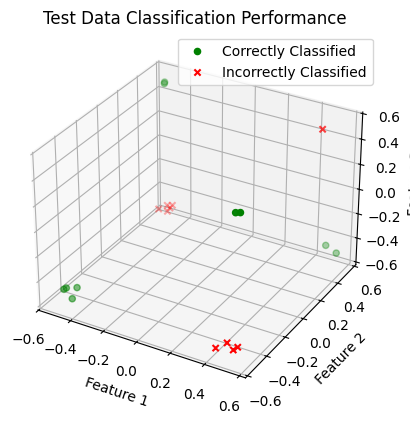

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

predictions = np.array([variational_classifier(weights, bias, x) for x in test_data])
accuracy = np.mean((predictions > 0.5) == test_labels)
print(f"Test Accuracy: {accuracy:.4f}")
correctly_classified = (predictions > 0.5) == test_labels
incorrectly_classified = ~correctly_classified

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(test_data[correctly_classified, 0], test_data[correctly_classified, 1], test_data[correctly_classified, 2],
           c='green', marker='o', label='Correctly Classified')

ax.scatter(test_data[incorrectly_classified, 0], test_data[incorrectly_classified, 1], test_data[incorrectly_classified, 2],
           c='red', marker='x', label='Incorrectly Classified')

ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
ax.set_title("Test Data Classification Performance")
ax.legend()

plt.show()